# Lung cancer Risk prdication

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from tqdm import tqdm  # Import tqdm

In [2]:
# Read the CSV file
filepath = 'survey lung cancer.csv'
df = pd.read_csv(filepath)

### Explorately Data Analysis

In [3]:
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [4]:
df.dtypes

GENDER                   object
AGE                       int64
SMOKING                   int64
YELLOW_FINGERS            int64
ANXIETY                   int64
PEER_PRESSURE             int64
CHRONIC DISEASE           int64
FATIGUE                   int64
ALLERGY                   int64
WHEEZING                  int64
ALCOHOL CONSUMING         int64
COUGHING                  int64
SHORTNESS OF BREATH       int64
SWALLOWING DIFFICULTY     int64
CHEST PAIN                int64
LUNG_CANCER              object
dtype: object

In [5]:
df.shape

(309, 16)

### Checking for Duplicates

In [6]:
# Check for duplicates
duplicates = df.duplicated()
duplicates.value_counts()

False    276
True      33
Name: count, dtype: int64

In [7]:
# Remove duplicates and keep the first occurrence of each row
df_cleaned = df.drop_duplicates()
df_cleaned.shape

(276, 16)

### Checking for Missing Values

In [8]:
# Get the sum of null values for each column
df_null = df_cleaned.isnull().sum()
# Filter to return only columns with null values and their counts
columns_with_nulls = df_null[df_null > 0]
# Display the result
print(columns_with_nulls)

Series([], dtype: int64)


In [9]:
# Select and print columns with data type 'object'
df_object = df_cleaned.select_dtypes(include=['object']).columns

print(df_object)

Index(['GENDER', 'LUNG_CANCER'], dtype='object')


In [10]:
df_cleaned.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [17]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode all 'object' columns
for column in df_object:
    df_cleaned[column] = label_encoder.fit_transform(df_cleaned[[column]])

F:\Anaconda\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_5364\469369767.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[column] = label_encoder.fit_transform(df_cleaned[[column]])
F:\Anaconda\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\Documents\Wondershare\CreatorT

In [18]:
df_cleaned.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0


F:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
F:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
F:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
F:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

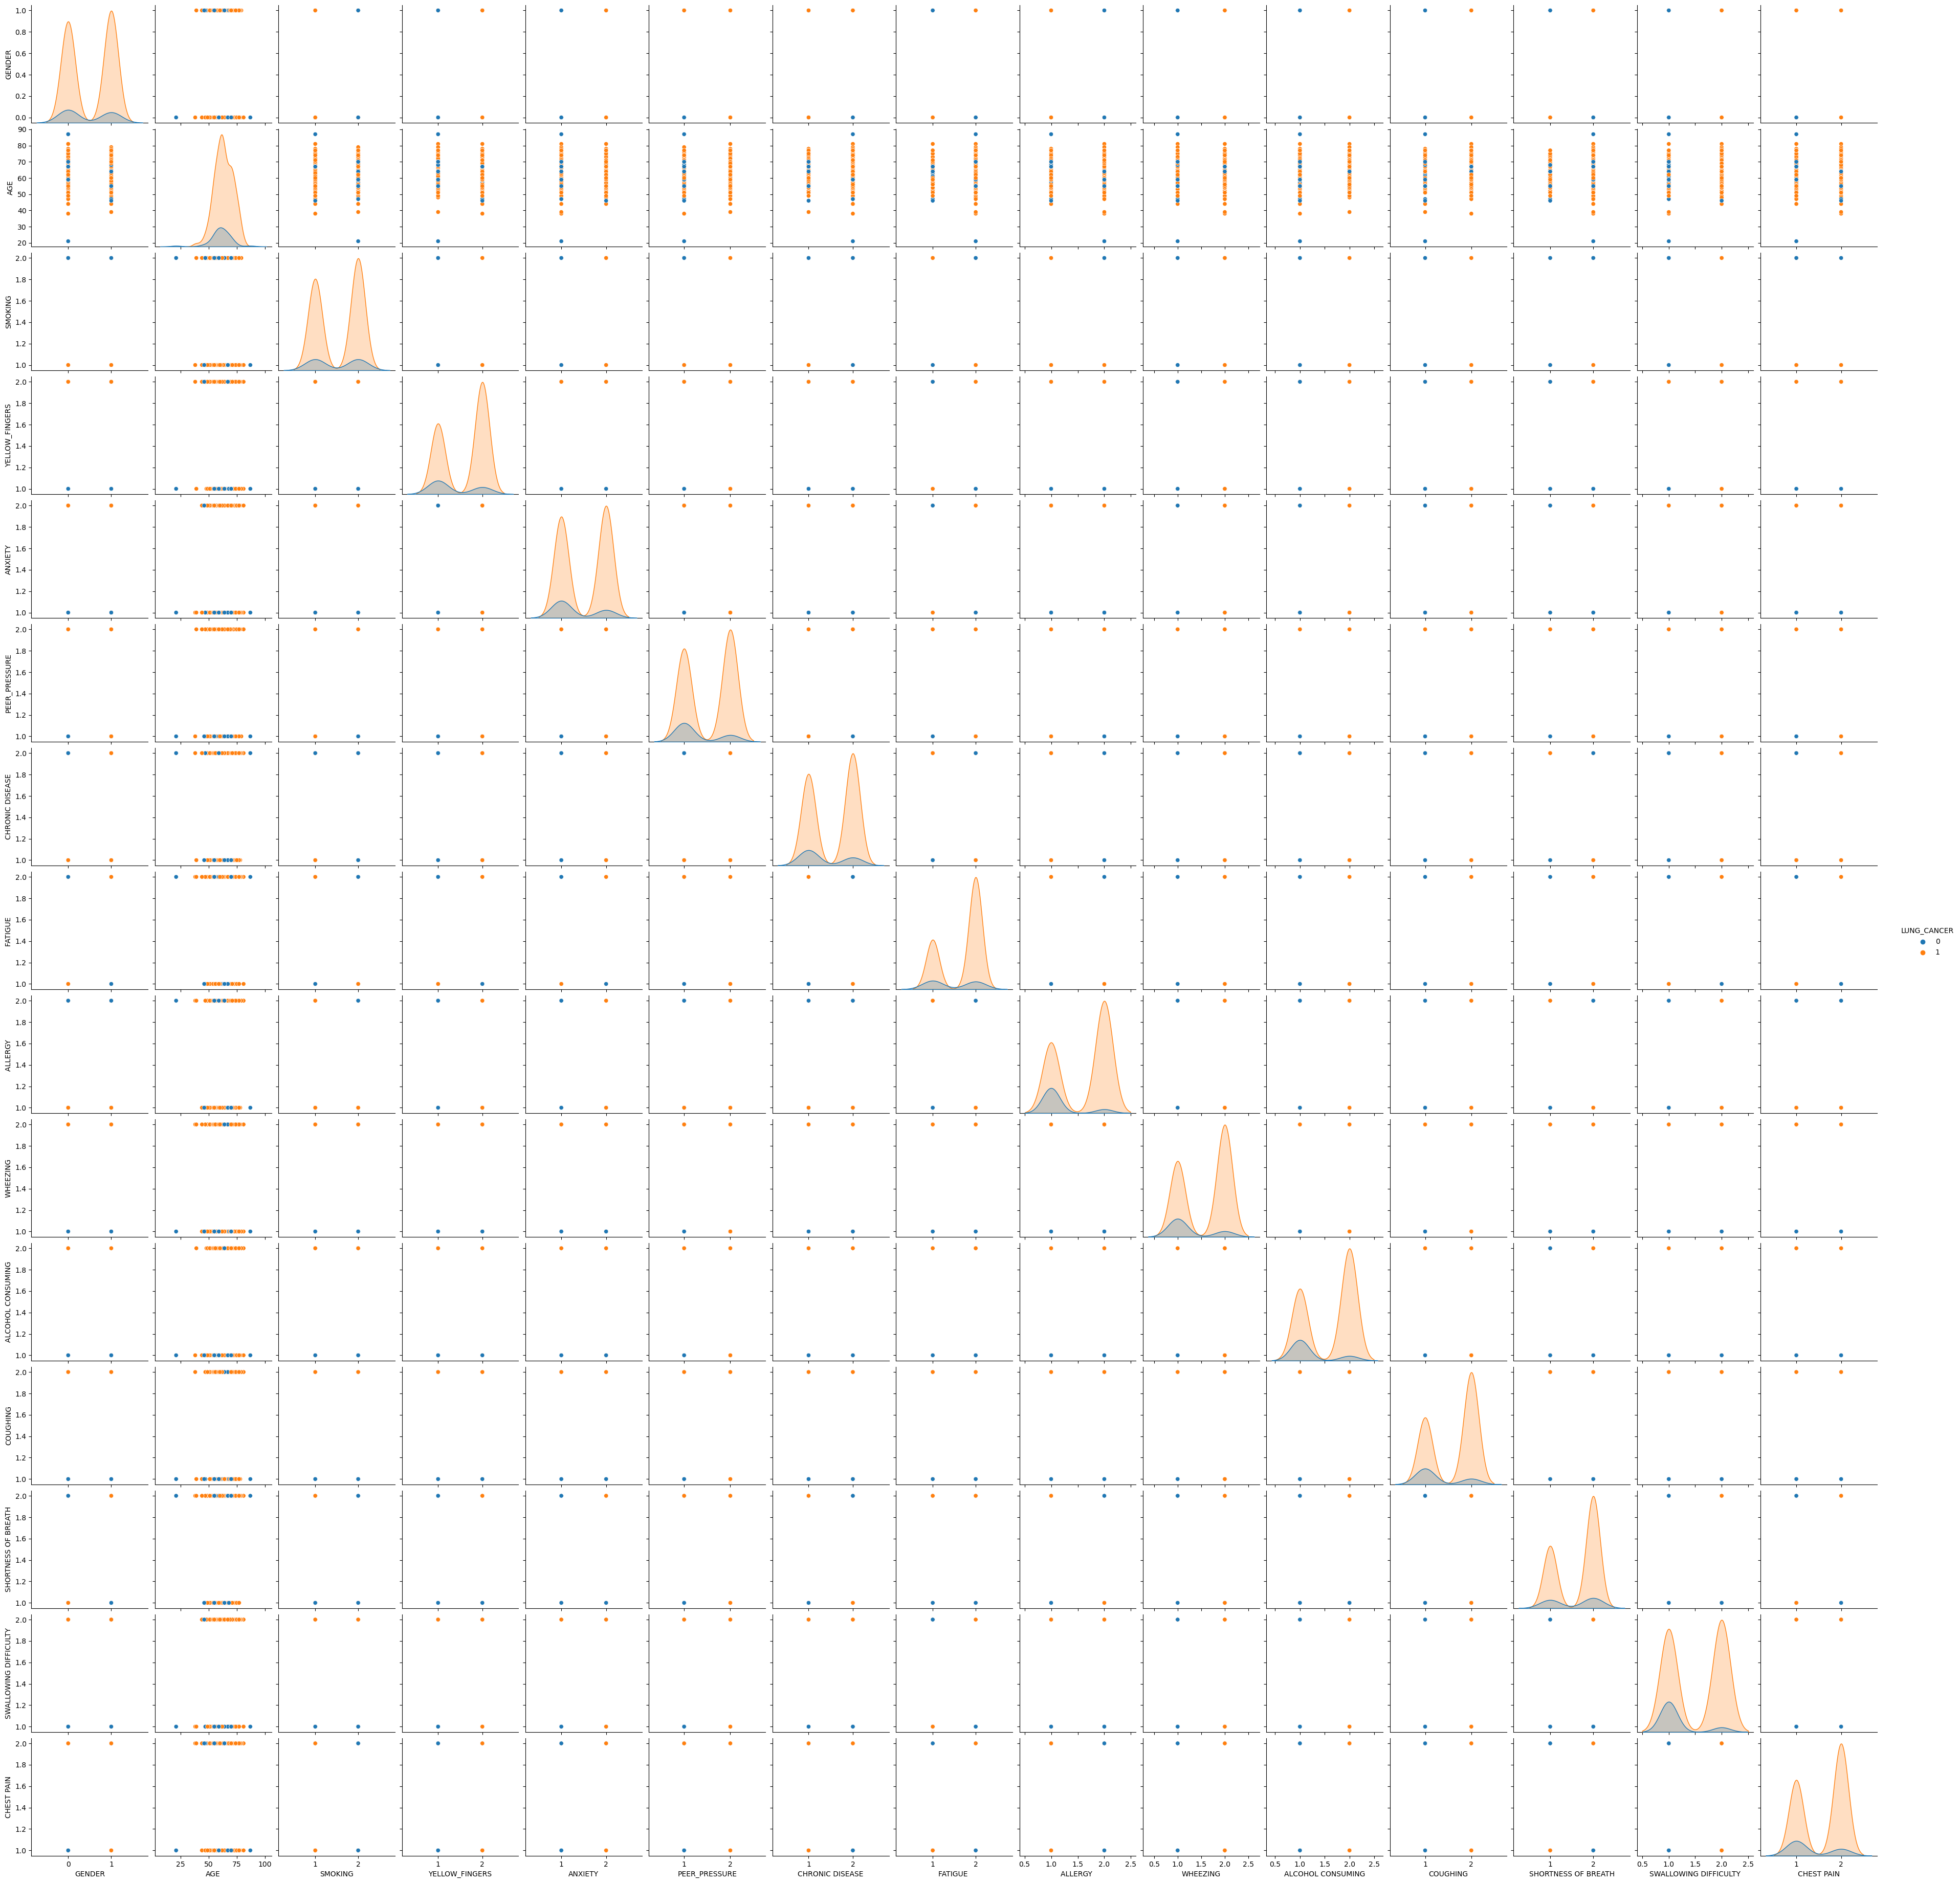

In [28]:
# May need to specify bandwidth (bw) in order to plot, else can delete the `, diag_kws={'bw': 0.2})` code.
sns.pairplot(df_cleaned, hue="LUNG_CANCER")

In [19]:
X = df_cleaned.drop(columns=['LUNG_CANCER'])  # Features (all columns except 'target')
y = df_cleaned['LUNG_CANCER']  # Target (the 'target' column)

In [20]:
#Apply StandardScaler to numeric columns
scaler = StandardScaler()
X['AGE'] = scaler.fit_transform(X[['AGE']])

In [21]:
X.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
0,1,0.728176,1,2,2,1,1,2,1,2,2,2,2,2,2
1,1,1.325964,2,1,1,1,2,2,2,1,1,1,2,2,2
2,0,-0.467401,1,1,1,2,1,2,1,2,1,2,2,1,2
3,1,0.010830,2,2,2,1,1,1,1,1,2,1,1,2,2
4,0,0.010830,1,2,1,1,1,1,1,2,1,2,2,1,1


In [22]:
y.value_counts()

LUNG_CANCER
1    238
0     38
Name: count, dtype: int64

In [23]:
# Print the unique labels and their encoded values
print("Original labels:", label_encoder.classes_)

Original labels: ['NO' 'YES']


### Checking the distribution of the target for unbalance dataset

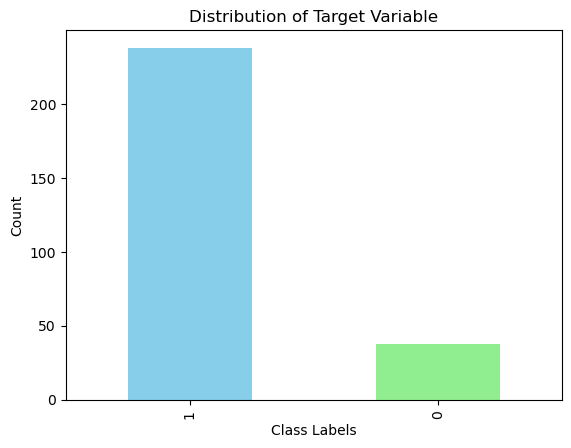

In [24]:
y.value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])

# Adding labels and title
plt.title("Distribution of Target Variable")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.savefig("Distribution of Target Variable")

### Splitting the dataset using the target for stratification

In [29]:
# Split the data into training and testing sets (using stratified sampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Logistic Regression model

In [30]:
# Step 2: Set up a pipeline with StandardScaler and Logistic Regression
pipe = Pipeline([
    
    ('logreg', LogisticRegression(max_iter=2000))  # Logistic Regression with multiple solvers
])

# Step 3: Define the hyperparameter grid for solvers, regularization, and tuning C
param_grid = {
    'logreg__penalty': ['l1', 'l2'],  # Regularization types: L1 and L2
    'logreg__C': np.logspace(-4, 4, 10),  # Tuning the regularization strength
    'logreg__solver': ['saga', 'liblinear']  # Solvers that support both L1 and L2 regularization
}

# Step 4: StratifiedKFold to stratify samples according to y
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 5: GridSearchCV to perform hyperparameter tuning with stratified sampling
grid_search_lg = GridSearchCV(pipe, param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 6: Fit the model using GridSearchCV
grid_search_lg.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = grid_search_lg.predict(X_test)

# Step 8: Evaluate the model with accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 9: Output the best hyperparameters and evaluation metrics
print(f"Best Hyperparameters: {grid_search_lg.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Hyperparameters: {'logreg__C': 2.782559402207126, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Accuracy: 0.9398
Precision: 0.9589
Recall: 0.9722
F1 Score: 0.9655


In [31]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":accuracy_score(y_test, model.predict(X_test)),"trian Accuracy": accuracy_score(y_train, model.predict(X_train))}

In [32]:
#test accuracy versus training accuray Logistic regression model
get_accuracy(X_train, X_test, y_train, y_test, grid_search_lg)

{'test Accuracy': 0.9397590361445783, 'trian Accuracy': 0.927461139896373}

In [33]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, roc_curve, auc, classification_report
import seaborn as sns

In [34]:
def plot_evaluation_metrics(y_true, y_pred, y_prob, class_names):
    """
    Plot evaluation metrics including confusion matrix and ROC curve.

    Parameters:
    - y_true: True labels (ground truth)
    - y_pred: Predicted labels
    - y_prob: Predicted probabilities (for ROC curve)
    - class_names: List of class names (for labeling confusion matrix)
    """
    
    cm = confusion_matrix(y_true, y_pred)

    # Create a figure with 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot confusion matrix on the first subplot (ax[0])
    sns.set_context('talk')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax[0], cmap='Blues', colorbar=False)
    ax[0].set_title('Confusion Matrix')
    
    # ROC Curve on the second subplot (ax[1])
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC Curve')
    ax[1].legend(loc="lower right")
    
    # Adjust the layout and display the plots
    plt.tight_layout()
    plt.show()
    plt.savefig("Confusion_lg")

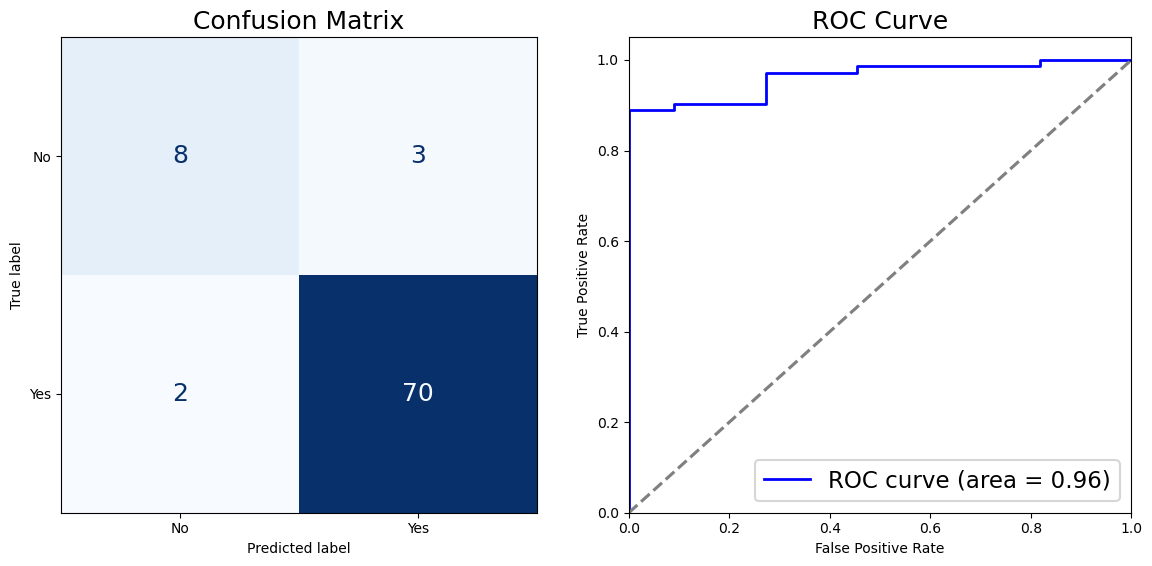

<Figure size 640x480 with 0 Axes>

In [35]:
y_prob = grid_search_lg.predict_proba(X_test)[:, 1]  # Using probabilities for ROC curve
class_names = ['No', 'Yes']
# Plot evaluation metrics
plot_evaluation_metrics(y_test, y_pred, y_prob, class_names)

In [36]:
# Classification Report (prints precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

          No       0.80      0.73      0.76        11
         Yes       0.96      0.97      0.97        72

    accuracy                           0.94        83
   macro avg       0.88      0.85      0.86        83
weighted avg       0.94      0.94      0.94        83



In [31]:
def plot_feature_importance(model, feature_names, top_n=16):
    # Get the coefficients from the Logistic Regression model
    if hasattr(model, "coef_"):
        importance = model.coef_[0]  # Get the coefficients for the first class
    else:
        raise ValueError("Model does not have coefficients.")

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Select the top N features
    top_importance_df = importance_df.head(top_n)

    # Assign colors based on the sign of the coefficients
    colors = ['red' if coef > 0 else 'green' for coef in top_importance_df['Importance']]

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(top_importance_df['Feature'], top_importance_df['Importance'], color=colors)
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importance')
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Add a vertical line at 0
    plt.show()

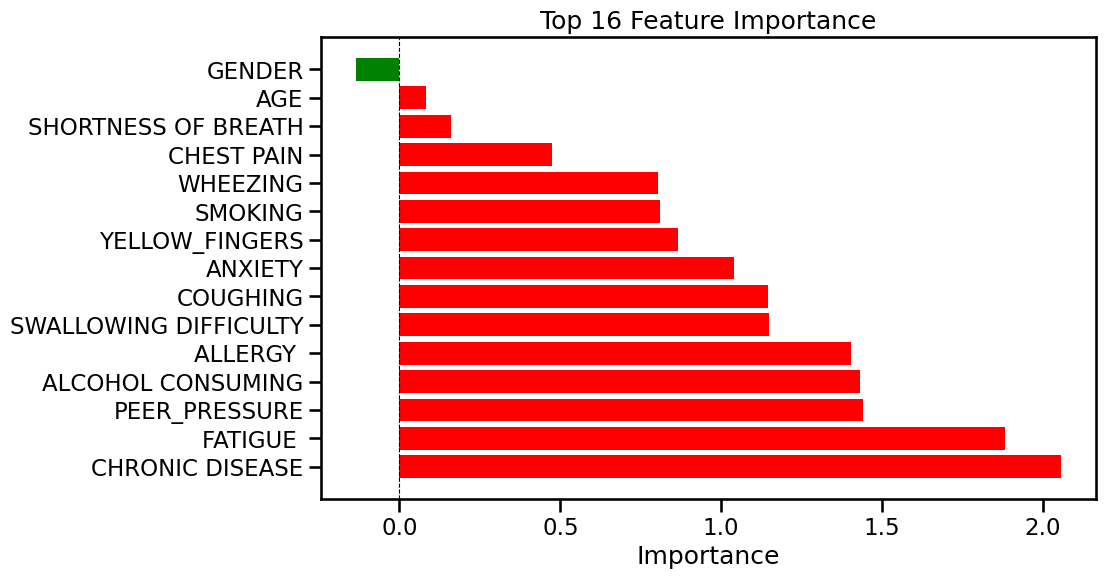

In [32]:
# Plot feature importance
best_model = grid_search_lg.best_estimator_.named_steps['logreg']  # Get the best logistic regression model
plot_feature_importance(best_model, X.columns)

### Logistic regression with class weight

In [33]:
# Step 2: Set up a pipeline with StandardScaler and Logistic Regression
pipe = Pipeline([
    
    ('logreg', LogisticRegression(max_iter=4000))  # Logistic Regression with multiple solvers
])

# Step 3: Define the hyperparameter grid for solvers, regularization, and tuning C
param_grid = {
    'logreg__penalty': ['l1', 'l2'],  # Regularization types: L1 and L2
    'logreg__C': np.logspace(-4, 4, 10),  # Tuning the regularization strength
    'logreg__solver': ['saga', 'liblinear'],  # Solvers that support both L1 and L2 regularization
    'logreg__class_weight': [{0: 0.85, 1: 0.15}]  # Class weights and option for no weighting
}

# Step 4: StratifiedKFold to stratify samples according to y
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 5: GridSearchCV to perform hyperparameter tuning with stratified sampling
grid_search_lgW = GridSearchCV(pipe, param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 6: Fit the model using GridSearchCV
grid_search_lgW.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = grid_search_lgW.predict(X_test)

# Step 8: Evaluate the model with accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 9: Output the best hyperparameters and evaluation metrics
print(f"Best Hyperparameters: {grid_search_lgW.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Hyperparameters: {'logreg__C': 0.046415888336127774, 'logreg__class_weight': {0: 0.85, 1: 0.15}, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Accuracy: 0.9277
Precision: 0.9853
Recall: 0.9306
F1 Score: 0.9571


In [34]:
#test accuracy versus training accuray Logistic regression model
get_accuracy(X_train, X_test, y_train, y_test, grid_search_lgW)

{'test Accuracy': 0.927710843373494, 'trian Accuracy': 0.8963730569948186}

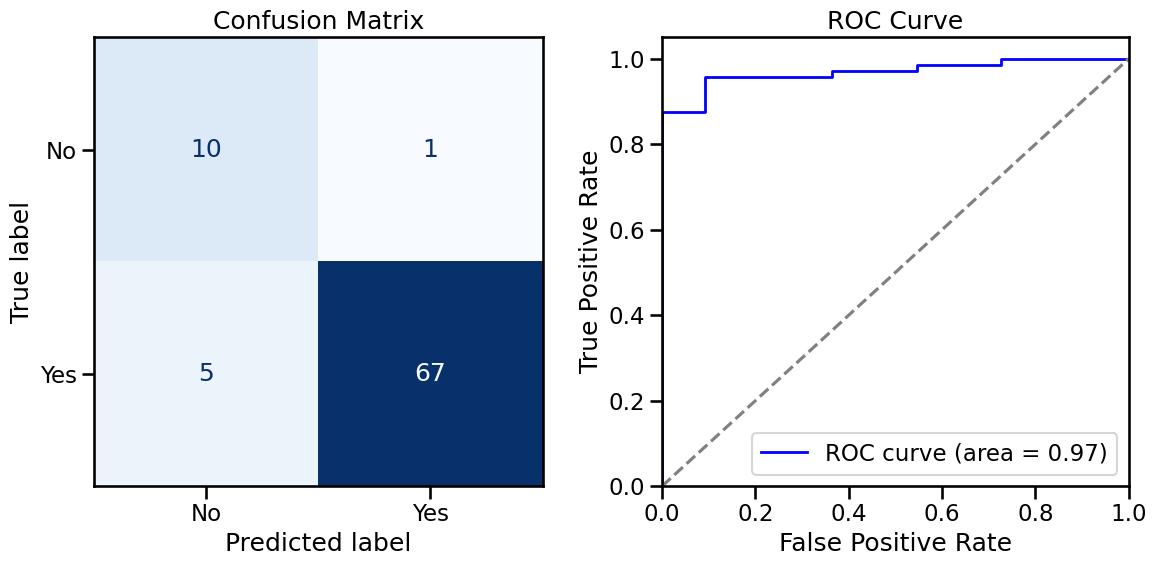

In [35]:
y_prob = grid_search_lgW.predict_proba(X_test)[:, 1]  # Using probabilities for ROC curve
class_names = ['No', 'Yes']
# Plot evaluation metrics
plot_evaluation_metrics(y_test, y_pred, y_prob, class_names)

In [36]:
# Classification Report (prints precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

          No       0.67      0.91      0.77        11
         Yes       0.99      0.93      0.96        72

    accuracy                           0.93        83
   macro avg       0.83      0.92      0.86        83
weighted avg       0.94      0.93      0.93        83



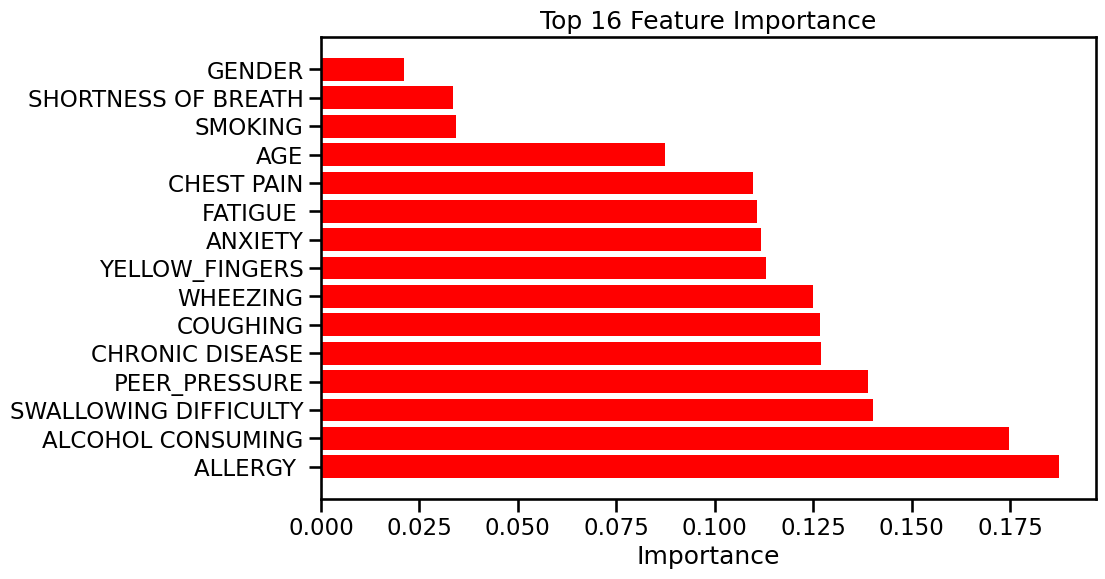

In [75]:
# Plot feature importance
best_model = grid_search_lgW.best_estimator_.named_steps['logreg']  # Get the best logistic regression model weighted
plot_feature_importance(best_model, X.columns)

### logistic Regression with polynomial features

In [37]:
# Step 2: Define the hyperparameter grid for polynomial features, solvers, regularization, and tuning C
param_grid = {
    'poly__degree': [2],  # Degree of polynomial features
    'logisticregression__penalty': ['l1', 'l2'],  # Regularization types: L1 and L2
    'logisticregression__C': np.logspace(-4, 4, 10),  # Tuning the regularization strength
    'logisticregression__solver': ['saga', 'liblinear'],  # Solvers that support both L1 and L2 regularization
    'logisticregression__max_iter': [4000]  # Ensure convergence
}

# Step 3: StratifiedKFold to stratify samples according to y
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: Create a pipeline to include polynomial features and logistic regression
pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),  # Polynomial features
    ('logisticregression', LogisticRegression())  # Logistic regression
])

# Step 5: GridSearchCV to perform hyperparameter tuning with stratified sampling
grid_search_lgP = GridSearchCV(pipeline, param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 6: Fit the model using GridSearchCV
grid_search_lgP.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = grid_search_lgP.predict(X_test)

# Step 8: Evaluate the model with accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 9: Output the best hyperparameters and evaluation metrics
print(f"Best Hyperparameters: {grid_search_lgP.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Hyperparameters: {'logisticregression__C': 0.046415888336127774, 'logisticregression__max_iter': 4000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga', 'poly__degree': 2}
Accuracy: 0.9157
Precision: 0.9333
Recall: 0.9722
F1 Score: 0.9524


In [38]:
get_accuracy(X_train, X_test, y_train, y_test, grid_search_lgP)

{'test Accuracy': 0.9156626506024096, 'trian Accuracy': 0.9222797927461139}

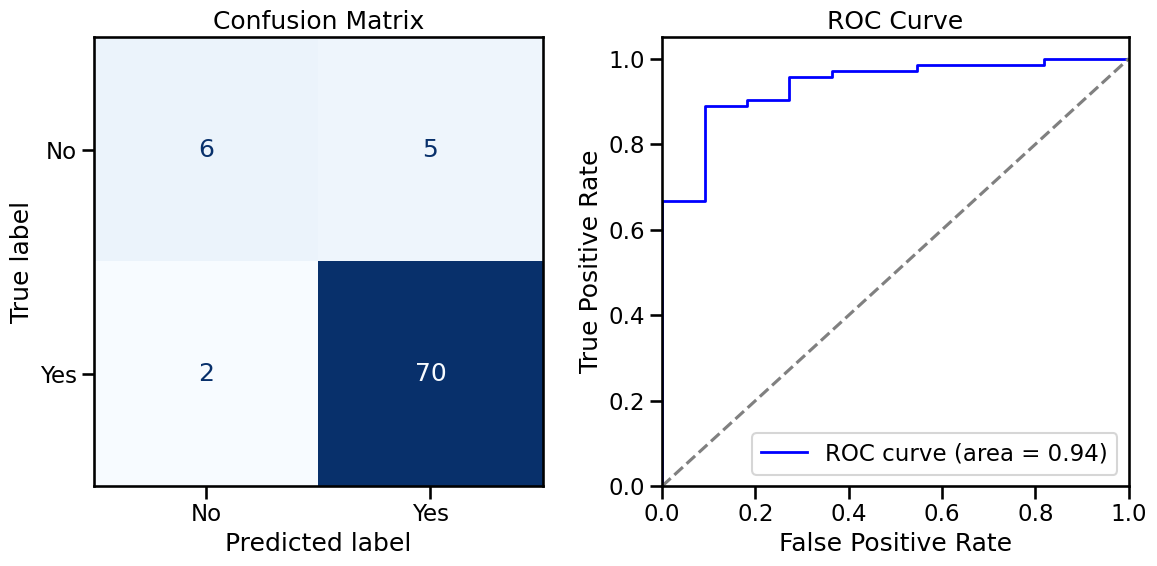

In [39]:
y_prob = grid_search_lgP.predict_proba(X_test)[:, 1]  # Using probabilities for ROC curve
class_names = ['No', 'Yes']
# Plot evaluation metrics
plot_evaluation_metrics(y_test, y_pred, y_prob, class_names)

In [40]:
# Classification Report (prints precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

          No       0.75      0.55      0.63        11
         Yes       0.93      0.97      0.95        72

    accuracy                           0.92        83
   macro avg       0.84      0.76      0.79        83
weighted avg       0.91      0.92      0.91        83



In [41]:
def plot_feature_importanceP(model, feature_names, top_n=16):
    # Get the coefficients from the Logistic Regression model
    if hasattr(model, "coef_"):
        importance = model.coef_[0]  # Get the coefficients for the first class
    else:
        raise ValueError("Model does not have coefficients.")

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Select the top N features
    top_importance_df = importance_df.head(top_n)

    # Assign colors based on the sign of the coefficients
    colors = ['red' if coef > 0 else 'green' for coef in top_importance_df['Importance']]

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(top_importance_df['Feature'], top_importance_df['Importance'], color=colors)
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importance')
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Add a vertical line at 0
    plt.show()

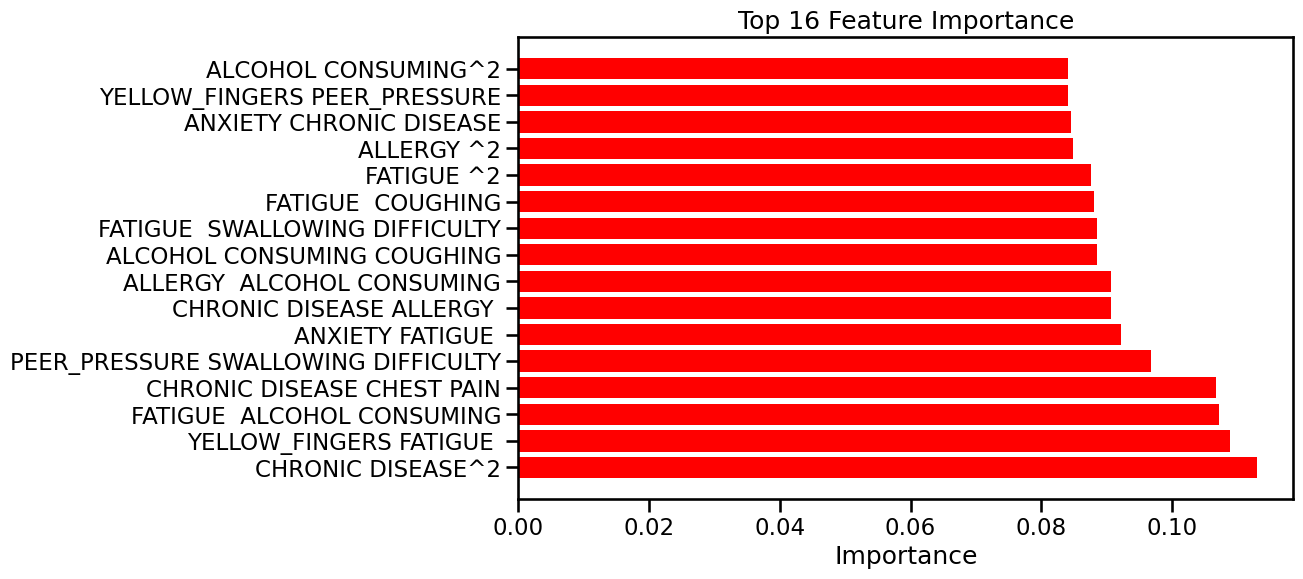

In [42]:
# Assuming you've used PolynomialFeatures and a pipeline
# Get the best logistic regression model
best_model = grid_search_lgP.best_estimator_.named_steps['logisticregression']

# Get the polynomial feature transformer
poly = grid_search_lgP.best_estimator_.named_steps['poly']

# Extract the new feature names after polynomial transformation
feature_names = poly.get_feature_names_out(X.columns)

# Plot the feature importance
plot_feature_importanceP(best_model, feature_names)

### Support Vector Machine

In [44]:
# Step 2: Define the hyperparameter grid for SVM
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Multiple kernels
    'gamma': ['scale', 'auto'],  # Kernel coefficient for RBF and polynomial
    'degree': [2, 3, 4],  # Degree for polynomial kernel
    'probability':[True]
}

# Step 3: StratifiedKFold to stratify samples according to y
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: GridSearchCV to perform hyperparameter tuning with stratified sampling
svm = SVC()
grid_search_svc = GridSearchCV(svm, param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 5: Fit the model using GridSearchCV
grid_search_svc.fit(X_train, y_train)

# Step 6: Make predictions on the test set
y_pred = grid_search_svc.predict(X_test)

# Step 7: Evaluate the model with accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 8: Output the best hyperparameters and evaluation metrics
print(f"Best Hyperparameters: {grid_search_svc.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Hyperparameters: {'C': 0.3593813663804626, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'probability': True}
Accuracy: 0.9277
Precision: 0.9459
Recall: 0.9722
F1 Score: 0.9589


In [45]:
get_accuracy(X_train, X_test, y_train, y_test, grid_search_svc)

{'test Accuracy': 0.927710843373494, 'trian Accuracy': 0.9326424870466321}

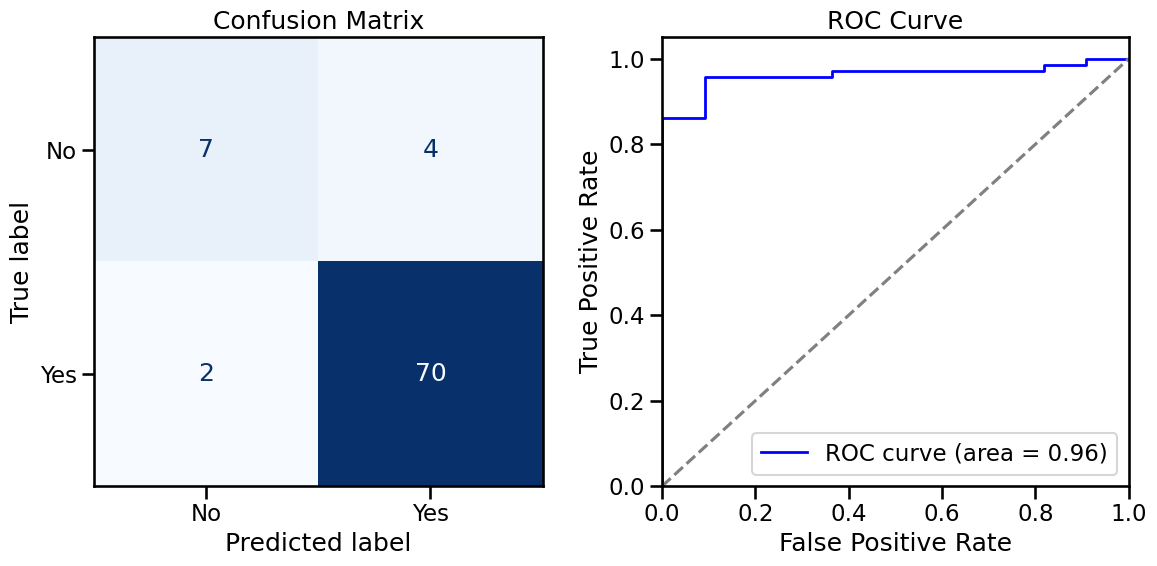

In [46]:
y_prob = grid_search_svc.predict_proba(X_test)[:, 1]  # Using probabilities for ROC curve
class_names = ['No', 'Yes']
# Plot evaluation metrics
plot_evaluation_metrics(y_test, y_pred, y_prob, class_names)

In [47]:
# Classification Report (prints precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

          No       0.78      0.64      0.70        11
         Yes       0.95      0.97      0.96        72

    accuracy                           0.93        83
   macro avg       0.86      0.80      0.83        83
weighted avg       0.92      0.93      0.92        83



### Support Vector Machine with Class weight

In [68]:
# Step 2: Define the hyperparameter grid for SVM
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Multiple kernels
    'gamma': ['scale', 'auto'],  # Kernel coefficient for RBF and polynomial
    'degree': [2, 3, 4],  # Degree for polynomial kernel
    'probability': [True],  # Enable probability estimates
    'class_weight': [{0: 0.85, 1: 0.15}]  # Set the class weights
}

# Step 3: StratifiedKFold to stratify samples according to y
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: GridSearchCV to perform hyperparameter tuning with stratified sampling
svm = SVC()
grid_search_svcW = GridSearchCV(svm, param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 5: Fit the model using GridSearchCV
grid_search_svcW.fit(X_train, y_train)

# Step 6: Make predictions on the test set
y_pred = grid_search_svcW.predict(X_test)

# Step 7: Evaluate the model with accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 8: Output the best hyperparameters and evaluation metrics
print(f"Best Hyperparameters: {grid_search_svc.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Hyperparameters: {'C': 0.3593813663804626, 'class_weight': {0: 0.85, 1: 0.15}, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
Accuracy: 0.9277
Precision: 0.9583
Recall: 0.9583
F1 Score: 0.9583


In [69]:
get_accuracy(X_train, X_test, y_train, y_test, grid_search_svcW)

{'test Accuracy': 0.927710843373494, 'trian Accuracy': 0.9222797927461139}

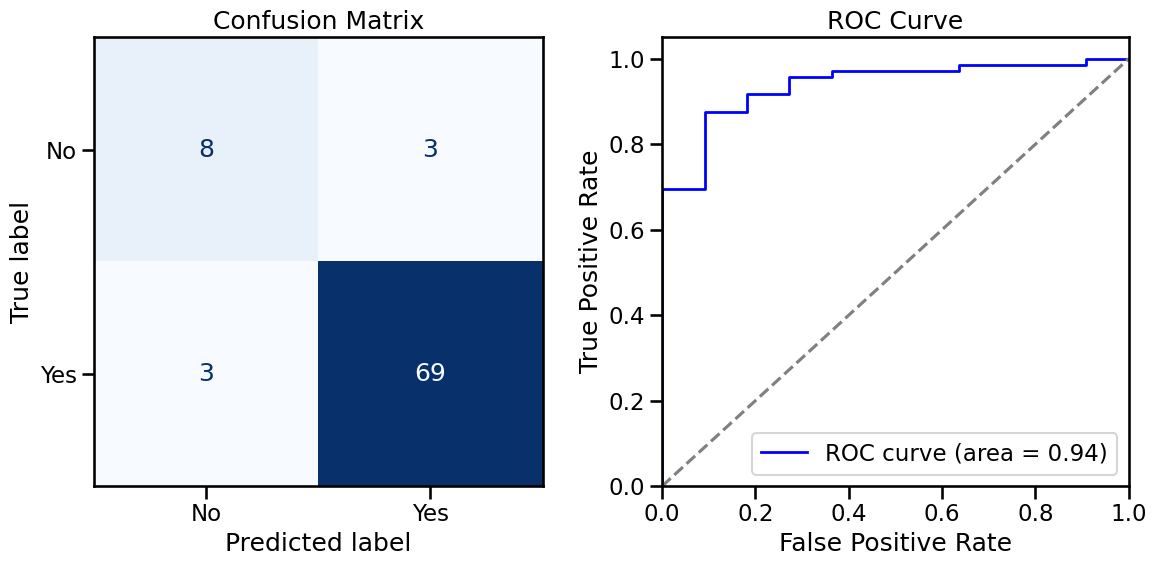

In [70]:
y_prob = grid_search_svcW.predict_proba(X_test)[:, 1]  # Using probabilities for ROC curve
class_names = ['No', 'Yes']
# Plot evaluation metrics
plot_evaluation_metrics(y_test, y_pred, y_prob, class_names)

In [71]:
# Classification Report (prints precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

          No       0.73      0.73      0.73        11
         Yes       0.96      0.96      0.96        72

    accuracy                           0.93        83
   macro avg       0.84      0.84      0.84        83
weighted avg       0.93      0.93      0.93        83



### Random Forest

In [52]:
# Step 2: Set up a pipeline with RandomForest
pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))  # RandomForest model
])

# Step 3: Define the hyperparameter grid for RandomForest
param_grid = {
    'rf__n_estimators': [100, 200, 300],        # Number of trees in the forest
    'rf__max_depth': [None, 10, 20],            # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],        # Minimum number of samples required to split a node
    'rf__min_samples_leaf': [1, 2, 4],          # Minimum number of samples required at a leaf node
    'rf__bootstrap': [True, False]              # Whether bootstrap samples are used when building trees
}

# Step 4: StratifiedKFold to stratify samples according to y
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 5: GridSearchCV to perform hyperparameter tuning with stratified sampling
grid_search_rf = GridSearchCV(pipe, param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 6: Fit the model using GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = grid_search_rf.predict(X_test)

# Step 8: Evaluate the model with accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 9: Output the best hyperparameters and evaluation metrics
print(f"Best Hyperparameters: {grid_search_rf.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Accuracy: 0.8916
Precision: 0.9091
Recall: 0.9722
F1 Score: 0.9396


In [53]:
get_accuracy(X_train, X_test, y_train, y_test, grid_search_rf)

{'test Accuracy': 0.891566265060241, 'trian Accuracy': 0.9326424870466321}

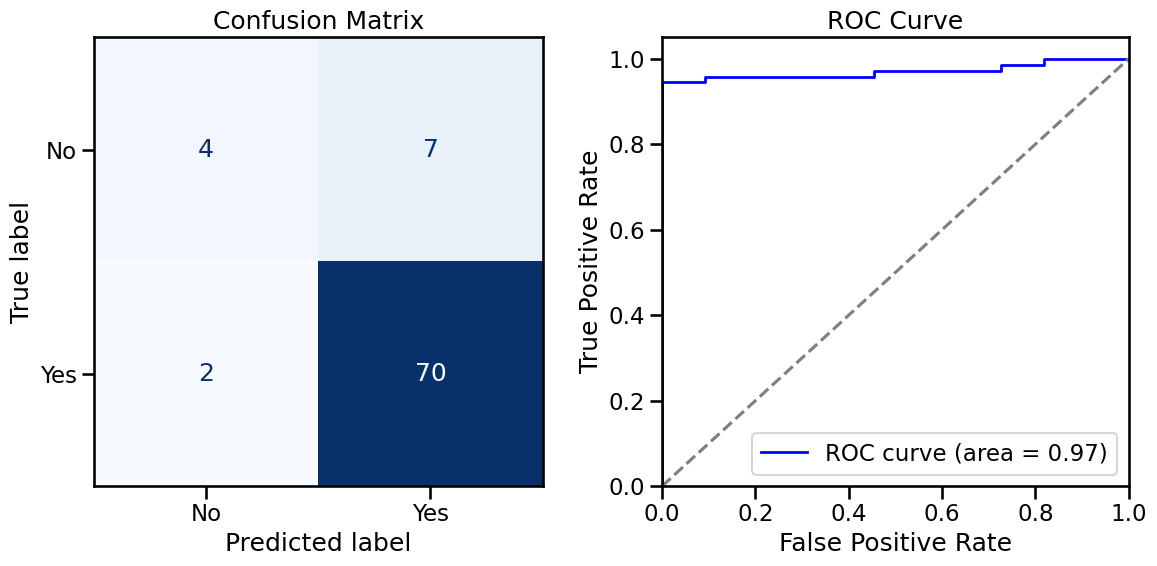

In [54]:
y_prob = grid_search_rf.predict_proba(X_test)[:, 1]  # Using probabilities for ROC curve
class_names = ['No', 'Yes']
# Plot evaluation metrics
plot_evaluation_metrics(y_test, y_pred, y_prob, class_names)

In [55]:
# Classification Report (prints precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

          No       0.67      0.36      0.47        11
         Yes       0.91      0.97      0.94        72

    accuracy                           0.89        83
   macro avg       0.79      0.67      0.71        83
weighted avg       0.88      0.89      0.88        83



### K-Nearest Neighbor (KNN)

In [56]:
# Step 2: Set up a pipeline with StandardScaler and KNeighborsClassifier
pipe = Pipeline([
    ('knn', KNeighborsClassifier())  # K-Nearest Neighbors classifier
])

# Step 3: Define the hyperparameter grid for KNN
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],           # Number of neighbors to consider
    'knn__weights': ['uniform', 'distance'],     # Weighting strategy
    'knn__metric': ['euclidean', 'manhattan'],   # Distance metric
}

# Step 4: StratifiedKFold to stratify samples according to y
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 5: GridSearchCV to perform hyperparameter tuning with stratified sampling
grid_search_knn = GridSearchCV(pipe, param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 6: Fit the model using GridSearchCV
grid_search_knn.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = grid_search_knn.predict(X_test)

# Step 8: Evaluate the model with accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 9: Output the best hyperparameters and evaluation metrics
print(f"Best Hyperparameters: {grid_search_knn.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
Accuracy: 0.9277
Precision: 0.9459
Recall: 0.9722
F1 Score: 0.9589


In [57]:
get_accuracy(X_train, X_test, y_train, y_test, grid_search_knn)

{'test Accuracy': 0.927710843373494, 'trian Accuracy': 0.9119170984455959}

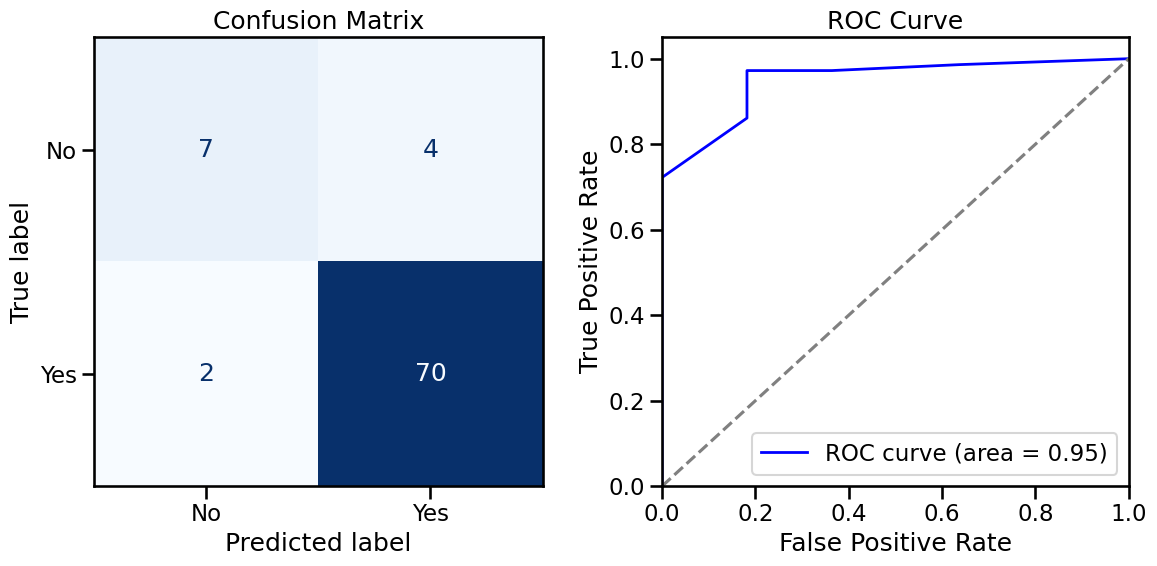

In [58]:
y_prob = grid_search_knn.predict_proba(X_test)[:, 1]  # Using probabilities for ROC curve
class_names = ['No', 'Yes']
# Plot evaluation metrics
plot_evaluation_metrics(y_test, y_pred, y_prob, class_names)

In [59]:
# Classification Report (prints precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

          No       0.78      0.64      0.70        11
         Yes       0.95      0.97      0.96        72

    accuracy                           0.93        83
   macro avg       0.86      0.80      0.83        83
weighted avg       0.92      0.93      0.92        83



### Stacking Classifier

In [64]:
estimators = [
    ('knn', KNeighborsClassifier()),  # Base KNN model
    ('svc', SVC(probability=True)),   # Base SVC model (probability=True for stacking)
    ('rf', RandomForestClassifier())  # Base Random Forest model
]

# Step 2: Define the final estimator (Logistic Regression)
final_estimator = LogisticRegression(max_iter=4000)

# Step 3: Set up the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=estimators,           # List of base estimators
    final_estimator=final_estimator, # Logistic Regression as final estimator
    passthrough=False,               # Pass original features to the final estimator or not
    n_jobs=-1
)

# Step 4: Create a pipeline with scaling for KNN and SVC
pipe = Pipeline([
    ('stacking', stacking_clf)         # Stacking Classifier as final model
])

# Step 5: Define the parameter grid for tuning the stacking classifier
# Once you provide the tuned hyperparameters for KNN, SVC, and Random Forest, update them here
param_grid = {
    # Tuned hyperparameters for KNN
    'stacking__knn__n_neighbors': [7],           # Number of neighbors to consider
    'stacking__knn__weights': ['uniform'],     # Weighting strategy
    'stacking__knn__metric': ['manhattan'],   # Distance metric
   
    # Tuned hyperparameters for SVC weighted
    'stacking__svc__C': [0.3593813663804626],  # Regularization parameter
    'stacking__svc__kernel': ['rbf'],  # Multiple kernels
    'stacking__svc__gamma': ['scale'],  # Kernel coefficient for RBF and polynomial
    'stacking__svc__degree': [2],  # Degree for polynomial kernel
    'stacking__svc__class_weight': [{0: 0.85, 1: 0.15}],
    'stacking__svc__probability': [True],

    # Tuned hyperparameters for Random Forest
    'stacking__rf__n_estimators': [300],  # Example values for Random Forest's number of trees
    'stacking__rf__max_depth': [None],       # Example values for Random Forest's tree depth
    'stacking__rf__min_samples_leaf': [2],
    'stacking__rf__bootstrap': [True],
    'stacking__rf__min_samples_split': [2],
    # Hyperparameters for Logistic Regression (final estimator)
    'stacking__final_estimator__C': [0.046415888336127774],  # Example regularization for logistic regression
    'stacking__final_estimator__penalty': ['l2'],
    'stacking__final_estimator__solver': ['saga'],
    'stacking__final_estimator__class_weight': [{0: 0.85, 1: 0.15}]
    
}

# Step 6: StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 7: GridSearchCV for hyperparameter tuning
grid_search_stacking = GridSearchCV(pipe, param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 8: Fit the model using GridSearchCV
grid_search_stacking.fit(X_train, y_train)

# Step 9: Make predictions on the test set
y_pred = grid_search_stacking.predict(X_test)

# Step 10: Evaluate the model with accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Step 11: Output the best hyperparameters and evaluation metrics
print(f"Best Hyperparameters: {grid_search_stacking.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: {'stacking__final_estimator__C': 0.046415888336127774, 'stacking__final_estimator__class_weight': {0: 0.85, 1: 0.15}, 'stacking__final_estimator__penalty': 'l2', 'stacking__final_estimator__solver': 'saga', 'stacking__knn__metric': 'manhattan', 'stacking__knn__n_neighbors': 7, 'stacking__knn__weights': 'uniform', 'stacking__rf__bootstrap': True, 'stacking__rf__max_depth': None, 'stacking__rf__min_samples_leaf': 2, 'stacking__rf__min_samples_split': 2, 'stacking__rf__n_estimators': 300, 'stacking__svc__C': 0.3593813663804626, 'stacking__svc__class_weight': {0: 0.85, 1: 0.15}, 'stacking__svc__degree': 2, 'stacking__svc__gamma': 'scale', 'stacking__svc__kernel': 'rbf', 'stacking__svc__probability': True}
Accuracy: 0.9157
Precision: 0.9333
Recall: 0.9722
F1 Score: 0.9524


In [65]:
get_accuracy(X_train, X_test, y_train, y_test, grid_search_stacking)

{'test Accuracy': 0.9156626506024096, 'trian Accuracy': 0.9222797927461139}

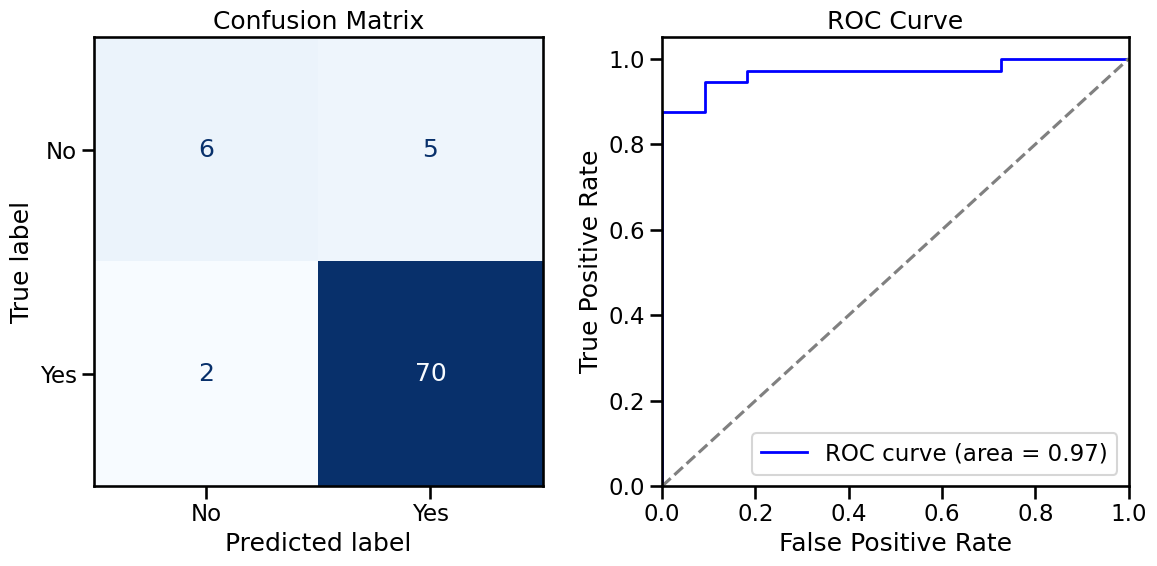

In [66]:
y_prob = grid_search_stacking.predict_proba(X_test)[:, 1]  # Using probabilities for ROC curve
class_names = ['No', 'Yes']
# Plot evaluation metrics
plot_evaluation_metrics(y_test, y_pred, y_prob, class_names)

In [67]:
# Classification Report (prints precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

          No       0.75      0.55      0.63        11
         Yes       0.93      0.97      0.95        72

    accuracy                           0.92        83
   macro avg       0.84      0.76      0.79        83
weighted avg       0.91      0.92      0.91        83



In [72]:
def evaluate_models(models, X_test, y_test):
    """
    Evaluates multiple models on accuracy, precision, recall, and F1 score, and returns a summary table and plot.

    Parameters:
    - models: Dictionary of trained models with their names as keys
    - X_test: Test set features
    - y_test: True labels of the test set

    Returns:
    - A pandas DataFrame containing evaluation metrics for each model
    - A bar plot comparing the models on the metrics
    """
    
    # Dictionary to store the results
    results = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': []
    }
    
    # Loop over each model and compute the metrics
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        
        # Append model's name and performance metrics to the results
        results['Model'].append(model_name)
        results['Accuracy'].append(accuracy_score(y_test, y_pred))
        results['Precision'].append(precision_score(y_test, y_pred))
        results['Recall'].append(recall_score(y_test, y_pred))
        results['F1 Score'].append(f1_score(y_test, y_pred))

    # Convert the results dictionary into a pandas DataFrame
    df_results = pd.DataFrame(results)

    # Display the table of results
    print(df_results)

    # Plot the results for comparison
    df_results.set_index('Model', inplace=True)
    df_results.plot(kind='bar', figsize=(10, 6))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.ylim([0, 1])  # All metrics are between 0 and 1
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    return df_results

      Model  Accuracy  Precision    Recall  F1 Score
0        Lg  0.939759   0.958904  0.972222  0.965517
1       LgW  0.927711   0.985294  0.930556  0.957143
2   Lg Poly  0.915663   0.933333  0.972222  0.952381
3       KNN  0.927711   0.945946  0.972222  0.958904
4       SVC  0.927711   0.958333  0.958333  0.958333
5      SVCW  0.927711   0.958333  0.958333  0.958333
6        RF  0.891566   0.909091  0.972222  0.939597
7  Stacking  0.915663   0.933333  0.972222  0.952381


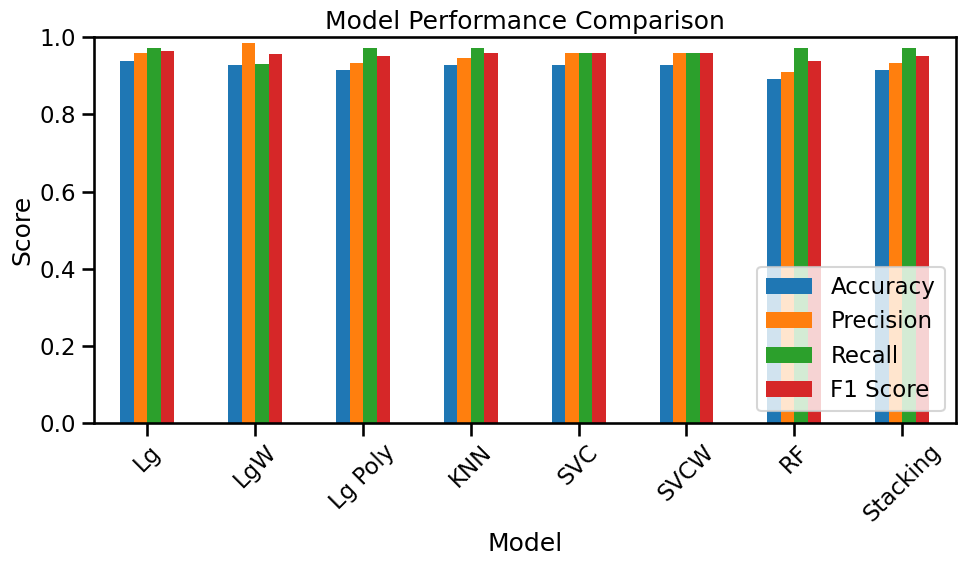

In [74]:
# Assuming grid_search or individual models are already trained
models = {
    'Lg': grid_search_lg,
    'LgW' : grid_search_lgW,
    'Lg Poly' : grid_search_lgP,
    'KNN': grid_search_knn,              
    'SVC': grid_search_svc, 
    'SVCW' : grid_search_svcW,
    'RF': grid_search_rf,     
    'Stacking': grid_search_stacking     
}

# Evaluate the models and get the results as a table and plot
results_df = evaluate_models(models, X_test, y_test)